In [1]:
import csv
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import datetime as dt
import pandas_datareader.data as web
import statsmodels.api as sm
from statsmodels.tsa.stattools import grangercausalitytests
from matplotlib import pyplot
import scipy.stats
from statsmodels.tsa.stattools import adfuller
from yahoofinancials import YahooFinancials
from statsmodels.tsa.ar_model import AR
%matplotlib inline

In [2]:
fpath = 'facebook_data_CNN_comments_sentiment_4dict.tsv'
post_data = pd.read_csv(fpath, sep='\t')
post_data.head()

,ID,PostID,PostDate,CommentID,CommentDate,CommenterURL,CommentText,WNPositive,WNNegative,WNNeutral,...,HVTokenQnt,HVSentiAvg,LMPositive,LMNegative,LMTokenQnt,LMSentiAvg,Vader_Positive,Vader_Negative,Vader_Neutral,Vader_Compound
0,0,1.016200e+16,2021-05-16 18:33:00,10162001834851509,NaN,profile.php?id=100006265364071&fref=nf&rc=p&r...,🇵🇸People are being killed in Jerusalem and the...,0.250,0.000,16.750,...,29,-0.172414,0,6,29,-0.206897,0.000,0.333,0.667,-0.9609
1,1,1.016200e+16,2021-05-16 18:33:00,10162001859716509,NaN,profile.php?id=100006965983736&fref=nf&rc=p&r...,You don't have to be Palestinian to support Pa...,0.625,0.500,15.875,...,32,0.156250,0,1,32,-0.031250,0.114,0.109,0.777,-0.2942
2,2,1.016200e+16,2021-05-16 18:33:00,10162001454896509,NaN,halaabdeen?fref=nf&rc=p&refid=52&__tn__=R,"If you don't know, children and women are bein...",0.250,0.625,22.125,...,41,0.097561,0,2,41,-0.048780,0.087,0.136,0.778,-0.7096
3,3,1.016200e+16,2021-05-16 18:33:00,10162002435461509,NaN,ToldusoAmerica?fref=nf&rc=p&refid=52&__tn__=R,Be aware public. Social media users are demand...,0.625,0.875,19.500,...,31,0.096774,0,0,31,0.000000,0.060,0.033,0.908,0.3818
4,4,1.016200e+16,2021-05-16 18:33:00,10162002426021509,NaN,ToldusoAmerica?fref=nf&rc=p&refid=52&__tn__=R,How do people like this CNN puts this guy on s...,1.125,1.375,18.500,...,37,0.081081,0,1,37,-0.027027,0.036,0.069,0.895,-0.3326


In [3]:
post_data['Vader_Average'] = post_data['Vader_Positive'] - post_data['Vader_Negative']

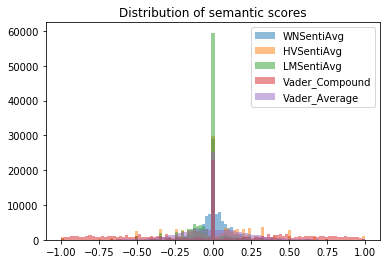

In [4]:
bins = np.linspace(-1, 1, 100)
pyplot.hist(post_data['WNSentiAvg'], bins, alpha=0.5, label='WNSentiAvg')
pyplot.hist(post_data['HVSentiAvg'], bins, alpha=0.5, label='HVSentiAvg')
pyplot.hist(post_data['LMSentiAvg'], bins, alpha=0.5, label='LMSentiAvg')
pyplot.hist(post_data['Vader_Compound'], bins, alpha=0.5, label='Vader_Compound')
pyplot.hist(post_data['Vader_Positive'] - post_data['Vader_Negative'], bins, alpha=0.5, label='Vader_Average')
pyplot.legend(loc='upper right')
pyplot.title('Distribution of semantic scores')
pyplot.show()

Text(0, 0.5, 'Posts')

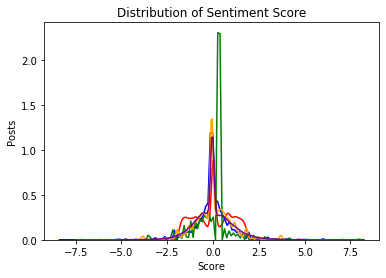

In [5]:


# seaborn histogram
sns.distplot((post_data['Vader_Compound'] - post_data['Vader_Compound'].mean())/post_data['Vader_Compound'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'red',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['WNSentiAvg'] - post_data['WNSentiAvg'].mean())/post_data['WNSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'blue',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['LMSentiAvg'] - post_data['LMSentiAvg'].mean())/post_data['LMSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'green',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['HVSentiAvg'] - post_data['HVSentiAvg'].mean())/post_data['HVSentiAvg'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'orange',
             hist_kws={'edgecolor':'black'})
sns.distplot((post_data['Vader_Average'] - post_data['Vader_Average'].mean())/post_data['Vader_Average'].std(), hist=False, kde=True, 
             bins=int(180/5), color = 'purple',
             hist_kws={'edgecolor':'black'})
# Add labels
plt.title('Distribution of Sentiment Score')
plt.xlabel('Score')
plt.ylabel('Posts')

In [6]:
post_data[['WNSentiAvg','HVSentiAvg','LMSentiAvg','Vader_Compound','Vader_Average']].describe()

,WNSentiAvg,HVSentiAvg,LMSentiAvg,Vader_Compound,Vader_Average
count,108201.000000,108201.000000,108201.000000,108201.000000,108201.000000
mean,0.009814,0.019076,-0.041571,-0.008325,0.009092
std,0.122799,0.265353,0.130971,0.531055,0.211991
min,-1.000000,-1.000000,-1.000000,-0.999700,-1.000000
25%,-0.034091,-0.111111,-0.083333,-0.449700,-0.106000
50%,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.053571,0.153846,0.000000,0.431000,0.117000
max,1.000000,1.000000,1.000000,0.999700,1.000000


In [7]:
post_data['PostDate'] = pd.to_datetime(post_data['PostDate'], errors='coerce')

post_data['DateMonth'] = post_data['PostDate'].dt.strftime('%Y-%m')
post_data['DateDay'] = post_data['PostDate'].dt.strftime('%Y-%m-%d')

In [8]:
post_data['DateMonth'].head()

0    2021-05
1    2021-05
2    2021-05
3    2021-05
4    2021-05
Name: DateMonth, dtype: object

In [9]:
post_data.columns

Index(['ID', 'PostID', 'PostDate', 'CommentID', 'CommentDate', 'CommenterURL',
       'CommentText', 'WNPositive', 'WNNegative', 'WNNeutral', 'WNSentiment',
       'WNTokenQnt', 'WNSentiAvg', 'HVPositive', 'HVNegative', 'HVTokenQnt',
       'HVSentiAvg', 'LMPositive', 'LMNegative', 'LMTokenQnt', 'LMSentiAvg',
       'Vader_Positive', 'Vader_Negative', 'Vader_Neutral', 'Vader_Compound',
       'Vader_Average', 'DateMonth', 'DateDay'],
      dtype='object')

In [10]:
Monthly_Data = post_data.groupby('DateMonth').agg({'WNSentiAvg': 'sum'
                                                         ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                       })

In [11]:
DailyData = post_data.groupby('DateDay').agg({'WNSentiAvg': 'sum'
                                                        ,'WNTokenQnt':'count'
                                                        ,'Vader_Compound':'mean'
                                                        ,'Vader_Average': 'mean'
                                                        ,'HVPositive':'sum'
                                                        ,'HVNegative':'sum'
                                                        ,'HVTokenQnt':'sum'
                                                        ,'LMPositive':'sum'
                                                        ,'LMNegative':'sum'
                                                        ,'LMTokenQnt':'sum'
                                                        })

In [12]:
DailyData['WNSentiment'] =  DailyData['WNSentiAvg']/ DailyData['WNTokenQnt']
DailyData['HVSentiment'] = (DailyData['HVPositive'] - DailyData['HVNegative'])/DailyData['HVTokenQnt']
DailyData['LMSentiment'] = (DailyData['LMPositive'] - DailyData['LMNegative'])/DailyData['LMTokenQnt']

Monthly_Data['WNSentiment'] =  Monthly_Data['WNSentiAvg']/ Monthly_Data['WNTokenQnt']
Monthly_Data['HVSentiment'] = (Monthly_Data['HVPositive'] - Monthly_Data['HVNegative'])/Monthly_Data['HVTokenQnt']
Monthly_Data['LMSentiment'] = (Monthly_Data['LMPositive'] - Monthly_Data['LMNegative'])/Monthly_Data['LMTokenQnt']



In [13]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['WNSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -5.0185
p-value                         0.0000
#Lags Used                      0.0000
Number of Observations Used    58.0000
Critical Value (1%)            -3.5485
Critical Value (5%)            -2.9128
Critical Value (10%)           -2.5941
dtype: float64


In [14]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['HVSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                 -5.0881
p-value                         0.0000
#Lags Used                      0.0000
Number of Observations Used    58.0000
Critical Value (1%)            -3.5485
Critical Value (5%)            -2.9128
Critical Value (10%)           -2.5941
dtype: float64


In [15]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['LMSentiment'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                 -5.0881
p-value                         0.0000
#Lags Used                      0.0000
Number of Observations Used    58.0000
Critical Value (1%)            -3.5485
Critical Value (5%)            -2.9128
Critical Value (10%)           -2.5941
dtype: float64
Results of Dickey-Fuller Test:


In [16]:
for i in range(len(dfoutput)):
    dfoutput[i] = round(dfoutput[i],4)
print(dfoutput)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(DailyData['Vader_Compound'].dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value


Test Statistic                 -3.9133
p-value                         0.0019
#Lags Used                      0.0000
Number of Observations Used    58.0000
Critical Value (1%)            -3.5485
Critical Value (5%)            -2.9128
Critical Value (10%)           -2.5941
dtype: float64
Results of Dickey-Fuller Test:


In [17]:
DailyData.head()

,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
DateDay,,,,,,,,,,,,,
2020-12-16,30.238911,1021,0.093527,0.047716,2166,1715,11701,312,736,11701,0.029617,0.038544,-0.036236
2020-12-17,26.330754,1672,0.021693,0.018613,3486,3078,19466,472,1328,19466,0.015748,0.020960,-0.043974
2020-12-18,25.108114,1013,0.064419,0.040006,1922,1610,11296,256,659,11296,0.024786,0.027620,-0.035676
2020-12-19,11.295884,643,0.028045,0.020006,1438,1193,8283,191,508,8283,0.017567,0.029579,-0.038271
2020-12-20,8.274869,257,0.138686,0.066514,569,458,3197,63,226,3197,0.032198,0.034720,-0.050985


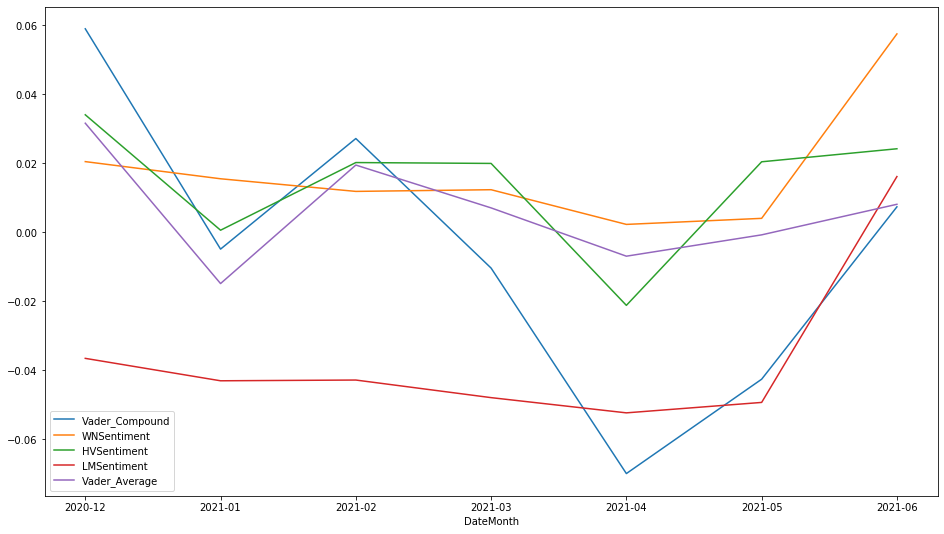

In [18]:
Monthly_Data[['Vader_Compound','WNSentiment','HVSentiment','LMSentiment','Vader_Average']].plot(legend=True, figsize=(16,9))

## Download S&P from Yahoo

In [19]:
#SnP_daily = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='d')
#SnP_monthly = web.get_data_yahoo('^GSPC','10/01/2010','05/01/2021',interval='m')
yahoo_financials = YahooFinancials(['^GSPC']).get_historical_price_data('2019-01-01','2021-05-31','daily')
SnP_daily =pd.DataFrame(yahoo_financials["^GSPC"]["prices"])
SnP_daily.index = SnP_daily['formatted_date']
SnP_daily['LogReturn'] = np.log(SnP_daily['adjclose']/SnP_daily['adjclose'].shift(1))

yahoo_financials_m = YahooFinancials(['^GSPC']).get_historical_price_data('2019-01-01','2021-05-31','monthly')
SnP_monthly =pd.DataFrame(yahoo_financials_m["^GSPC"]["prices"])
SnP_monthly.index = SnP_monthly['formatted_date']
SnP_monthly['LogReturn'] = np.log(SnP_monthly['adjclose']/SnP_monthly['adjclose'].shift(1))


In [20]:
#SnP_daily['LogReturn'] = np.log(SnP_daily['Adj Close']/SnP_daily['Adj Close'].shift(1))

In [21]:
#SnP_monthly.index = SnP_monthly.index.strftime('%Y-%m')

AttributeError: 'Index' object has no attribute 'strftime'

In [22]:
SnP_monthly['LogReturn'] = np.log(SnP_monthly['Adj Close']/SnP_monthly['Adj Close'].shift(1))

## Granger test

In [20]:
Granger_data_daily = pd.merge(SnP_daily,DailyData, how= 'inner', left_index=True, right_index=True)

In [21]:
def grangerTest(exog, endog):
    MAX_LAG = 30
    ARaic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(exog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numExog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for exog data is " + str(numExog))

    ARaic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="aic")
    ARbic = AR(endog.tolist()).fit(maxlag=MAX_LAG, ic="bic")
    # select the fewer number of parameters between both criteria.
    numEndog = len(ARaic.params) if len(ARaic.params) < len(ARbic.params) else len(ARbic.params)

    print ("Optimal number of lags for endog data is " + str(numEndog))

    # now that I know the optimal number of parameters, I can call the
    # granger causality function of statsmodels.
    data = pd.concat([endog, exog], axis=1)
    print ("\nGranger causality results of indep onto dep")
    results = grangercausalitytests(data, maxlag=numEndog)

    data = pd.concat([exog, endog], axis=1)
    print ("\nGranger causality results of dep onto indep")
    results = grangercausalitytests(data, maxlag=numExog)
    regr = results[2][1]
    print (regr[0].params)
    print (regr[1].params)
    print (regr[1].pvalues)

In [25]:
Granger_data_monthly = pd.merge(SnP_monthly,Monthly_Data, how= 'inner', left_index=True, right_index=True)

In [26]:
#Granger_data['SS_LogReturn'] = np.log((Granger_data['SentimentScoreAdj']+1)/(Granger_data['SentimentScoreAdj']+1).shift(1))

In [27]:
Granger_data_monthly

,High,Low,Open,Close,Volume,Adj Close,LogReturn,WNSentiAvg,WNTokenQnt,Vader_Compound,Vader_Average,HVPositive,HVNegative,HVTokenQnt,LMPositive,LMNegative,LMTokenQnt,WNSentiment,HVSentiment,LMSentiment
2011-06,1345.199951,1258.069946,1345.199951,1320.640015,86122730000,1320.640015,-0.018426,0.000000,1,-0.631000,-0.165000,0,1,8,0,1,8,0.000000,-0.125000,-0.125000
2011-07,1356.479980,1282.859985,1320.640015,1292.280029,81102170000,1292.280029,-0.021708,0.057692,2,0.484350,0.124500,5,0,26,0,0,26,0.028846,0.192308,0.000000
2011-08,1307.380005,1101.540039,1292.589966,1218.890015,108419170000,1218.890015,-0.058468,0.102652,7,0.298771,0.235571,16,5,51,1,0,51,0.014665,0.215686,0.019608
2011-09,1229.290039,1114.219971,1219.119995,1131.420044,102786820000,1131.420044,-0.074467,-0.062500,5,-0.160040,-0.090800,0,6,18,0,5,18,-0.012500,-0.333333,-0.277778
2011-10,1292.660034,1074.770020,1131.209961,1253.300049,98063670000,1253.300049,0.102307,0.053971,10,0.251150,0.100300,21,9,83,3,6,83,0.005397,0.144578,-0.036145
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01,3870.899902,3662.709961,3764.610107,3714.239990,105548790000,3714.239990,-0.011199,76.404470,2123,0.106775,0.047973,3653,2259,19638,603,999,19638,0.035989,0.070985,-0.020165
2021-02,3950.429932,3725.620117,3731.169922,3811.149902,98596960000,3811.149902,0.025757,35.554546,1008,0.104644,0.036783,1739,846,9117,282,399,9117,0.035272,0.097949,-0.012833
2021-03,3994.409912,3723.340088,3842.510010,3972.889893,120863560000,3972.889893,0.041563,50.886415,1283,0.160192,0.072603,2566,1455,13705,413,628,13705,0.039662,0.081065,-0.015688
2021-04,4218.779785,3992.780029,3992.780029,4181.169922,82869290000,4181.169922,0.051097,31.388089,946,0.111396,0.041881,1853,1109,10004,321,498,10004,0.033180,0.074370,-0.017693


In [22]:
Vars = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]
for Var in Vars:
    print("\n" + Var + "\n")
    grangerTest(Granger_data_daily[Var], Granger_data_daily['LogReturn'])


Vader_Compound

Optimal number of lags for exog data is 16
Optimal number of lags for endog data is 10

Granger causality results of indep onto dep

Granger Causality
number of lags (no zero) 1
ssr based F test:         F=0.1094  , p=0.7428  , df_denom=36, df_num=1
ssr based chi2 test:   chi2=0.1185  , p=0.7307  , df=1
likelihood ratio test: chi2=0.1183  , p=0.7309  , df=1
parameter F test:         F=0.1094  , p=0.7428  , df_denom=36, df_num=1

Granger Causality
number of lags (no zero) 2
ssr based F test:         F=0.0980  , p=0.9070  , df_denom=33, df_num=2
ssr based chi2 test:   chi2=0.2256  , p=0.8933  , df=2
likelihood ratio test: chi2=0.2249  , p=0.8936  , df=2
parameter F test:         F=0.0980  , p=0.9070  , df_denom=33, df_num=2

Granger Causality
number of lags (no zero) 3
ssr based F test:         F=0.1480  , p=0.9302  , df_denom=30, df_num=3
ssr based chi2 test:   chi2=0.5475  , p=0.9083  , df=3
likelihood ratio test: chi2=0.5435  , p=0.9092  , df=3
parameter F test:      

C:\Users\Windows\anaconda3\lib\site-packages\statsmodels\tsa\ar_model.py:691: FutureWarning: 
statsmodels.tsa.AR has been deprecated in favor of statsmodels.tsa.AutoReg and
statsmodels.tsa.SARIMAX.

AutoReg adds the ability to specify exogenous variables, include time trends,
and add seasonal dummies. The AutoReg API differs from AR since the model is
treated as immutable, and so the entire specification including the lag
length must be specified when creating the model. This change is too
substantial to incorporate into the existing AR api. The function
ar_select_order performs lag length selection for AutoReg models.

AutoReg only estimates parameters using conditional MLE (OLS). Use SARIMAX to
estimate ARX and related models using full MLE via the Kalman Filter.

To silence this warning and continue using AR until it is removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

  warnings.warn(AR_DEPRECATION_WARN, FutureWarning)


ValueError: Insufficient observations. Maximum allowable lag is 12

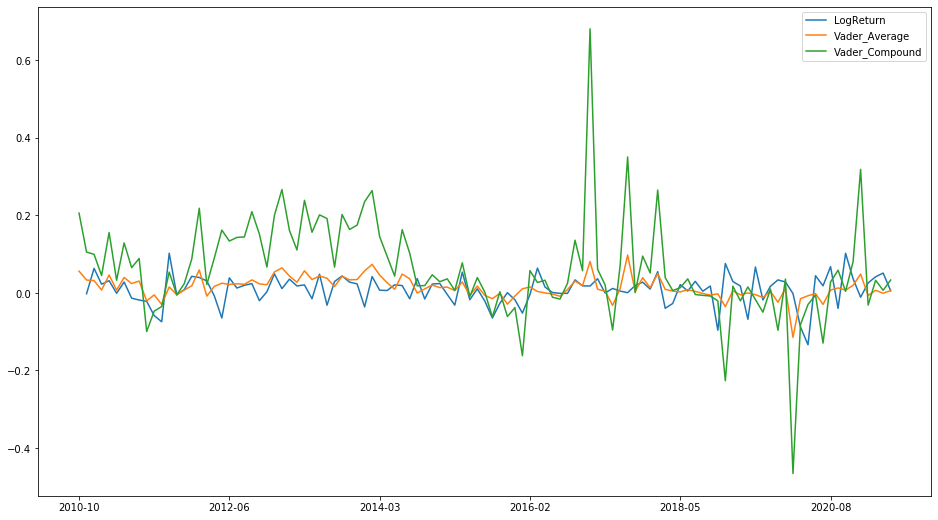

In [33]:
Granger_data_monthly[['LogReturn','Vader_Average','Vader_Compound']].plot(legend=True, figsize=(16,9))

In [23]:
corr = Granger_data_daily[["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment","LogReturn"]].corr()
corr.style.background_gradient(cmap='coolwarm')

,Vader_Compound,Vader_Average,WNSentiment,HVSentiment,LMSentiment,LogReturn
Vader_Compound,1.000000,0.977021,0.808213,0.883348,0.929671,-0.039255
Vader_Average,0.977021,1.000000,0.831466,0.867374,0.904191,-0.039958
WNSentiment,0.808213,0.831466,1.000000,0.743104,0.735056,0.090310
HVSentiment,0.883348,0.867374,0.743104,1.000000,0.867240,-0.009668
LMSentiment,0.929671,0.904191,0.735056,0.867240,1.000000,-0.051626
LogReturn,-0.039255,-0.039958,0.090310,-0.009668,-0.051626,1.000000


In [24]:
pvals = [] 
for col in ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"]:
    pvals.append(scipy.stats.linregress(Granger_data_daily['LogReturn'][1:], Granger_data_daily[col][1:].dropna())[3])
corr_signif = pd.DataFrame(pvals,columns = ['p-value']
                           ,index = ["Vader_Compound","Vader_Average","WNSentiment","HVSentiment","LMSentiment"])
corr_signif

,p-value
Vader_Compound,0.791710
Vader_Average,0.783760
WNSentiment,0.589071
HVSentiment,0.941563
LMSentiment,0.743024


In [38]:
pvals_mnt = [] 
for col in ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average']:
    pvals_mnt.append(scipy.stats.linregress(Granger_data_monthly['LogReturn'][1:], Granger_data_monthly[col][1:].dropna())[3])
corr_signif_mnt = pd.DataFrame(pvals_mnt,columns = ['p-value']
                           ,index = ['Vader_Compound','Flair_Score','SentimentScoreAdj','Vader_Average'])
corr_signif_mnt

,p-value
Vader_Compound,0.084306
Flair_Score,0.977764
SentimentScoreAdj,0.311650
Vader_Average,0.047369
